In [1]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align
import matplotlib.pyplot as plt
from MDAnalysis.analysis.distances import dist
from tqdm import tqdm
import pandas as pd
import pickle
import red

/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
def obtain_RMSD(run_numbers, species='complex', eq_ref=False):

    if species == 'complex':
        if eq_ref == False:
            filename = 'RMSD.csv'
        else:
            filename = 'RMSD_eq_ref.csv'
    elif species == 'CK1a':
        filename = 'RMSD_CK1a.csv'
    else:
        filename = 'RMSD_CRBN.csv'

    if isinstance(run_numbers, int):
        run_numbers = [run_numbers]

    RMSDs = []

    for run_number in run_numbers:
        df = pd.read_csv(f"results/run{run_number}/{filename}")
        time = df['Time (ns)'].to_numpy()
        RMSDs.append(df['RMSD (Angstrom)'].to_numpy())

    RMSDs = np.array(RMSDs)

    return time, np.average(RMSDs, axis=0)


In [3]:
def obtain_RMSF(run_number, species='complex'):

    if species == 'complex':
        filename = 'RMSF.csv'
    elif species == 'CK1a':
        filename = 'RMSF_CK1a.csv'
    else:
        filename = 'RMSF_CRBN.csv'

    df = pd.read_csv(f"results/run{run_number}/{filename}")

    residx = df['Residue index'].to_numpy()
    RMSF = df['RMSF (Angstrom)'].to_numpy()

    return residx, RMSF

In [4]:
def obtain_av_RMSF(run_numbers, species='complex'):

    RMSFs = []

    for run_number in run_numbers:

        res, rmsf = obtain_RMSF(run_number, species)
        RMSFs.append(rmsf)

    RMSFs = np.array(RMSFs)

    return res, np.average(RMSFs, axis=0), np.std(RMSFs, axis=0)
        

In [5]:
def obtain_CA_idx(u, res_idx):
    """Function to obtain the index of the alpha carbon for a given residue index"""
    
    selection_str = f"protein and resid {res_idx} and name CA"
    
    selected_CA = u.select_atoms(selection_str)

    if len(selected_CA.indices) == 0:
        print('CA not found for the specified residue...')
    
    elif len(selected_CA.indices) > 1:
        print('Multiple CAs found, uh oh...')

    else:  
        return selected_CA.indices[0]

In [6]:
def obtain_distance(pos1, pos2):
    
    return np.linalg.norm(pos1 - pos2)

In [7]:
def obtain_angle(pos1, pos2, pos3):

    return mda.lib.distances.calc_angles(pos1, pos2, pos3)

In [8]:
def obtain_dihedral(pos1, pos2, pos3, pos4):
    
    return mda.lib.distances.calc_dihedrals(pos1, pos2, pos3, pos4)

## Plotting RMSD

Text(0, 0.5, 'RMSD (AA)')

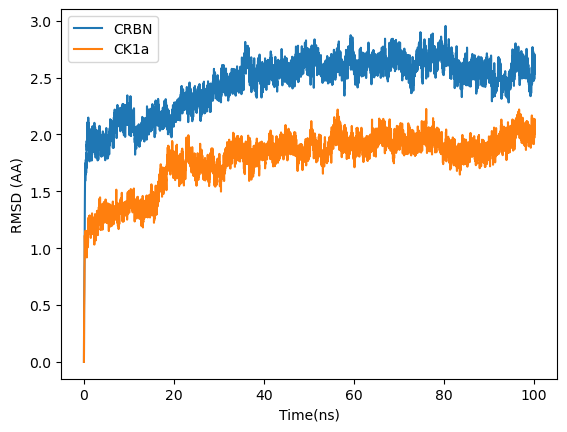

In [9]:
run_numbers = [1,2,3]

systems = ['CRBN', 'CK1a']

for species in systems:

    time, RMSD = obtain_RMSD(run_numbers, species, eq_ref=False)
    plt.plot(time, RMSD, label=species)

plt.legend()
plt.xlabel('Time(ns)')
plt.ylabel('RMSD (AA)')

## Plotting interface RMSD

In [10]:
# Functions to calculate interface RMSD

def generate_selection_str(indices):
    """
    Generate the MDAnalysis string for a given array of indices
    """
    selection_str = "resid "

    for index in indices:
        selection_str+=f"{index} "

    selection_str+='and name N CA C'

    return selection_str

def obtain_interface_RMSD(run_number):
    """
    Obtain the interface RMSD 
    """
    rec_interface = [37, 38, 39, 79, 80, 237, 238, 239, 240, 241, 242, 243, 244, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 273, 274, 275, 276, 277, 279, 280, 281, 282, 283, 284, 285, 286, 287, 305]
    lig_interface = [319, 320, 321, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 371, 372, 378, 379, 380, 393, 394, 395, 396, 397, 448, 449, 450, 451, 452]

    # Add lenalidomide to interface
    len_selection = 'resname LVY and not name H*'
    
    interface_res = np.append(rec_interface, lig_interface)
    interface_selection_str = generate_selection_str(interface_res)

    prmtop = "structures/complex.prmtop"
    dcd = f"results/run{run_number}/traj.dcd"

    u = mda.Universe(prmtop, dcd)

    dry_system = u.select_atoms("not resname HOH or resname WAT")

    ref = dry_system
    R_u =rms.RMSD(dry_system, ref, select=f"({interface_selection_str}) or ({len_selection})")
    R_u.run()

    rmsd_u = R_u.rmsd.T #take transpose
    time = rmsd_u[1]/1000 # Units of ns
    rmsd = rmsd_u[2]

    return time, rmsd

def obtain_av_interface_RMSD(run_numbers):
    """
    Obtain average interface RMSD
    """ 

    RMSDs = []

    for run_number in run_numbers:

        time, rmsd = obtain_interface_RMSD(run_number)
        RMSDs.append(rmsd)

    RMSDs = np.array(RMSDs)

    return time, np.average(RMSDs, axis=0)

In [12]:
# Obtain interface RMSD
# time, av_RMSD = obtain_av_interface_RMSD([1,2,3])
# df = pd.DataFrame()
# df['Time (ns)'] = time
# df['Interface RMSD (Angstrom)'] = av_RMSD
# df.to_csv('results/av_iRMSD.csv')

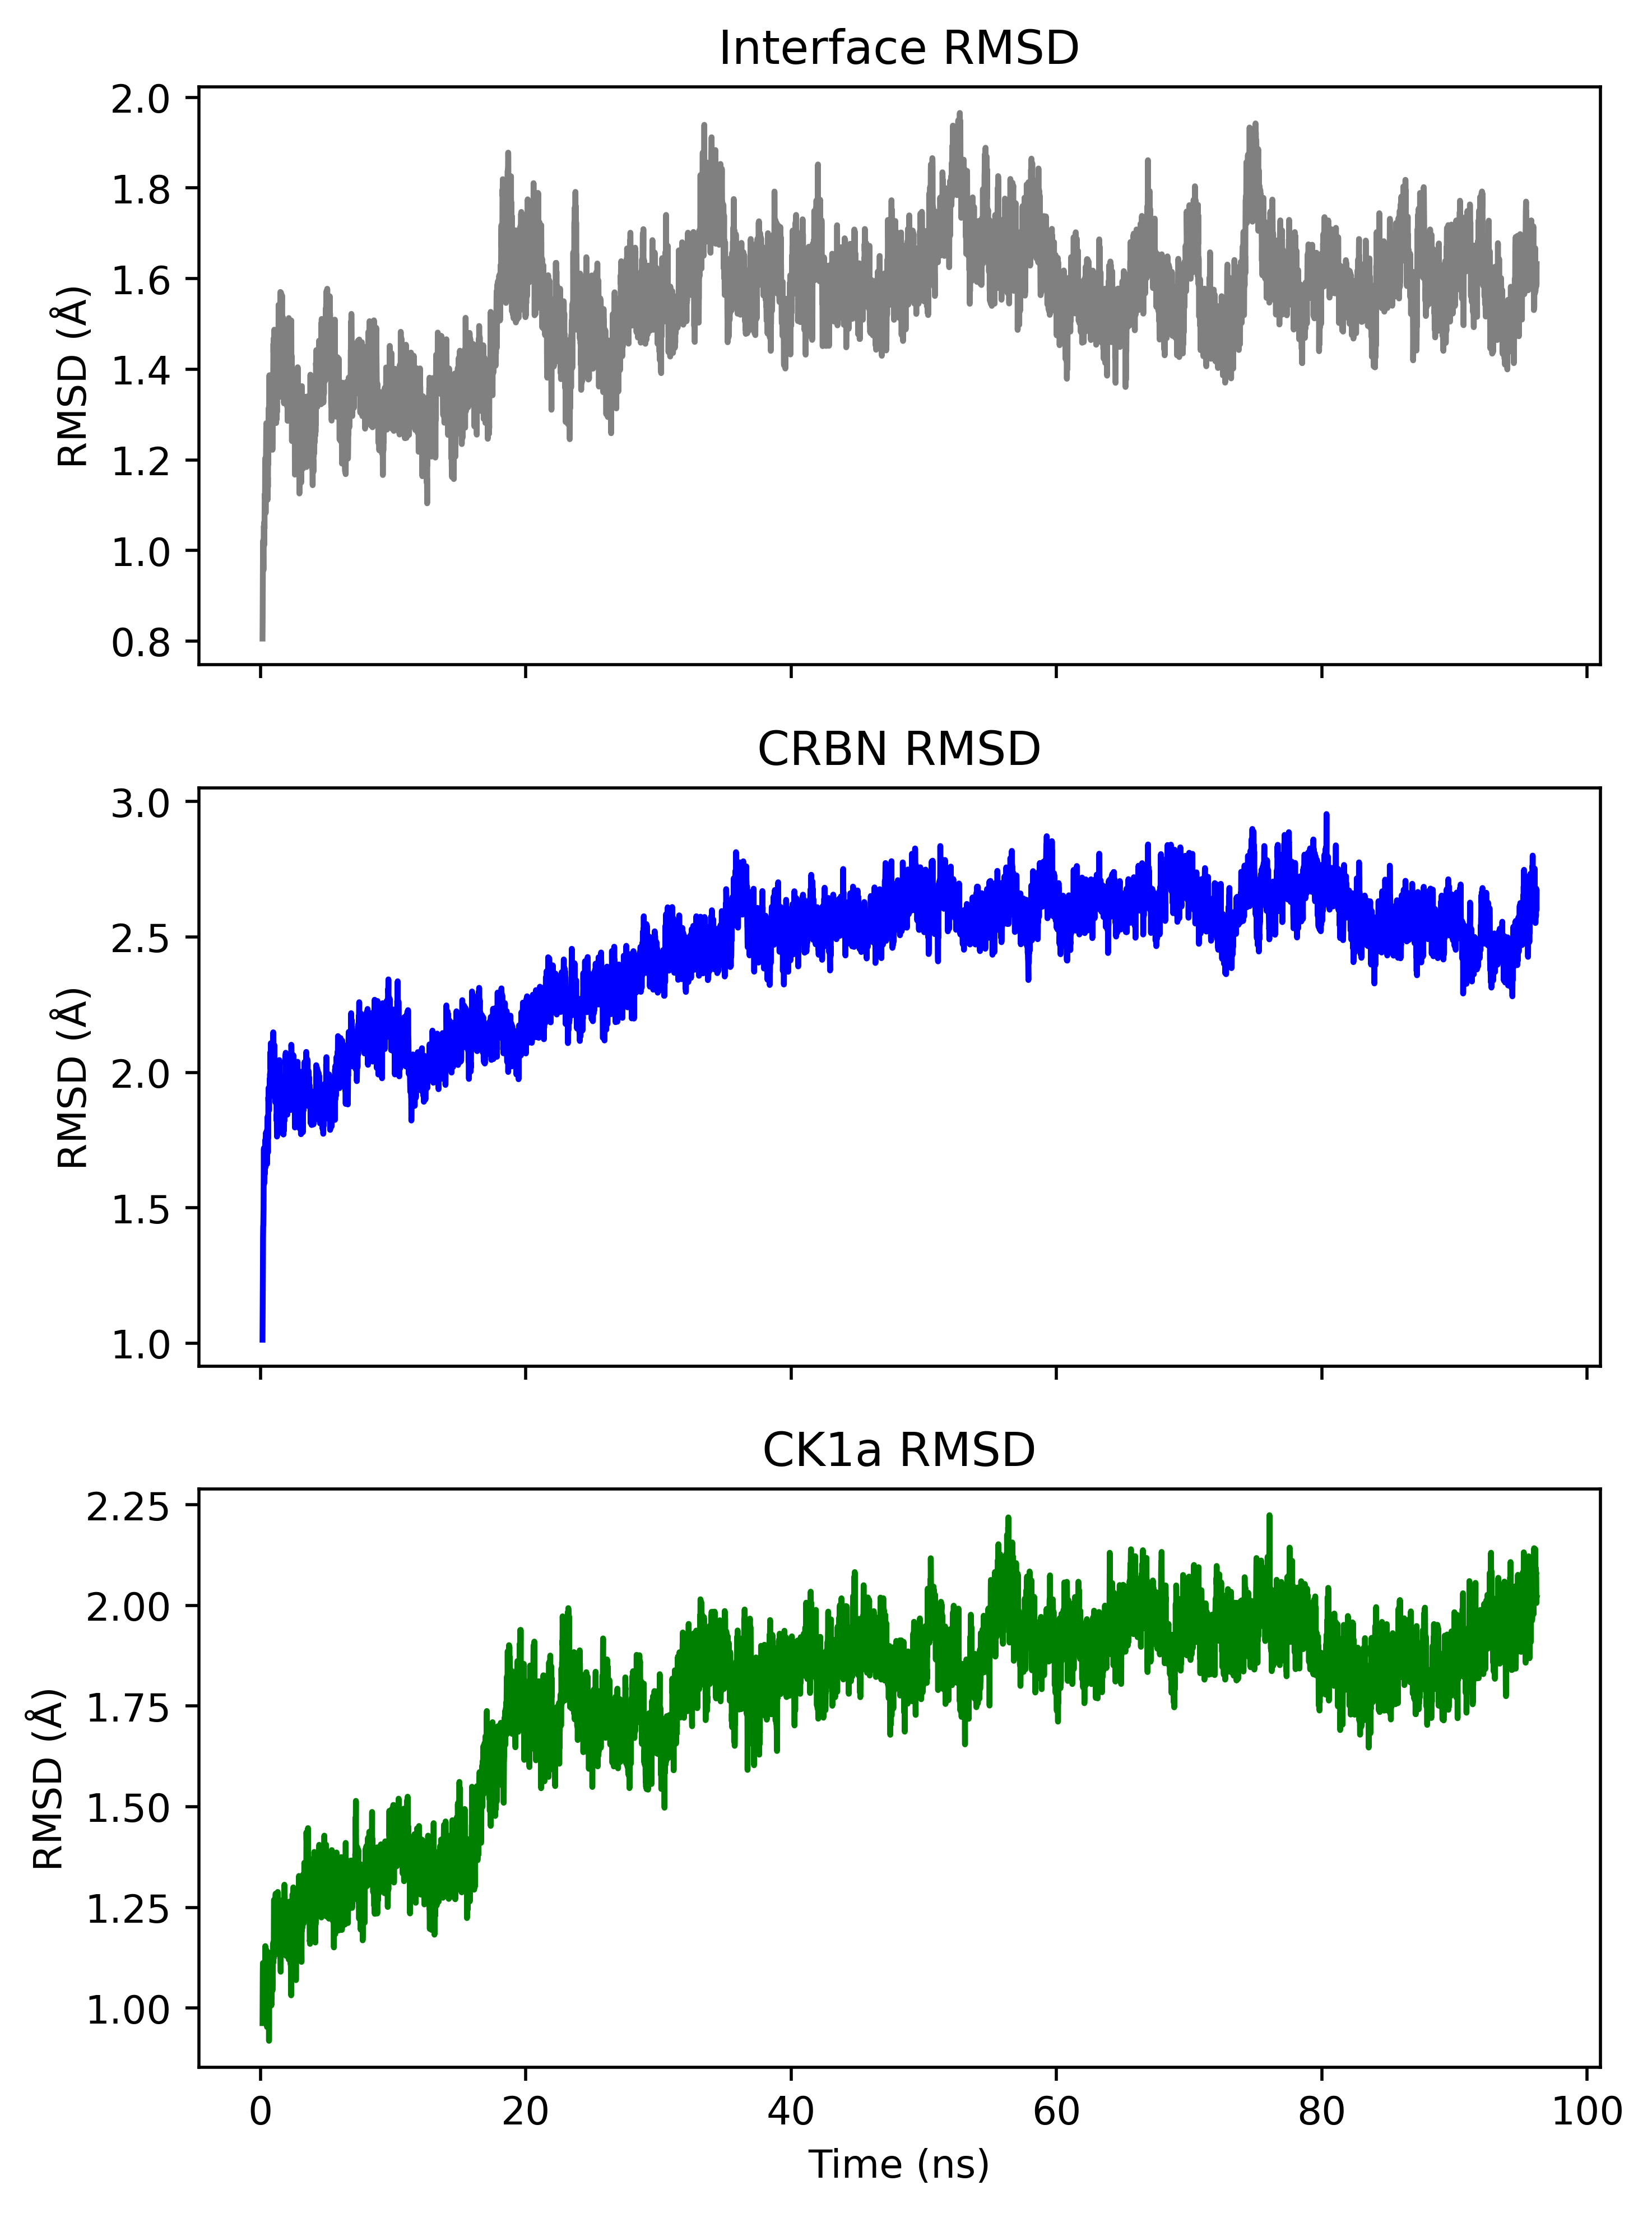

In [13]:
run_numbers = [1, 2, 3]

# Load the interface RMSD data
df = pd.read_csv('results/av_iRMSD.csv')
time_interface, iRMSD = df['Time (ns)'], df['Interface RMSD (Angstrom)']

# Define systems
systems = ['CRBN', 'CK1a']

start_idx = 15 # cutoff index for RMSD plotting
stop_idx = -400

# Create subplots for each RMSD plot
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 8), dpi=500, sharex=True)

# Plot Interface RMSD
axs[0].plot(time_interface[start_idx:stop_idx], iRMSD[start_idx:stop_idx], c='grey', label='Interface')
axs[0].set_ylabel('RMSD (Å)')
axs[0].set_title('Interface RMSD')

colors = {'CK1a':'g', 'CRBN':'b'}

# Plot each system's RMSD
for i, species in enumerate(systems, start=1):
    time, RMSD = obtain_RMSD(run_numbers, species)
    axs[i].plot(time[start_idx:stop_idx], RMSD[start_idx:stop_idx], c=colors[species], label=species)
    axs[i].set_ylabel('RMSD (Å)')
    axs[i].set_title(f'{species} RMSD')

# Set common x-label
plt.xlabel('Time (ns)')

# Adjust layout
plt.tight_layout()

plt.show()

## Plotting RMSF

Text(0, 0.5, 'Average RMSF (Å)')

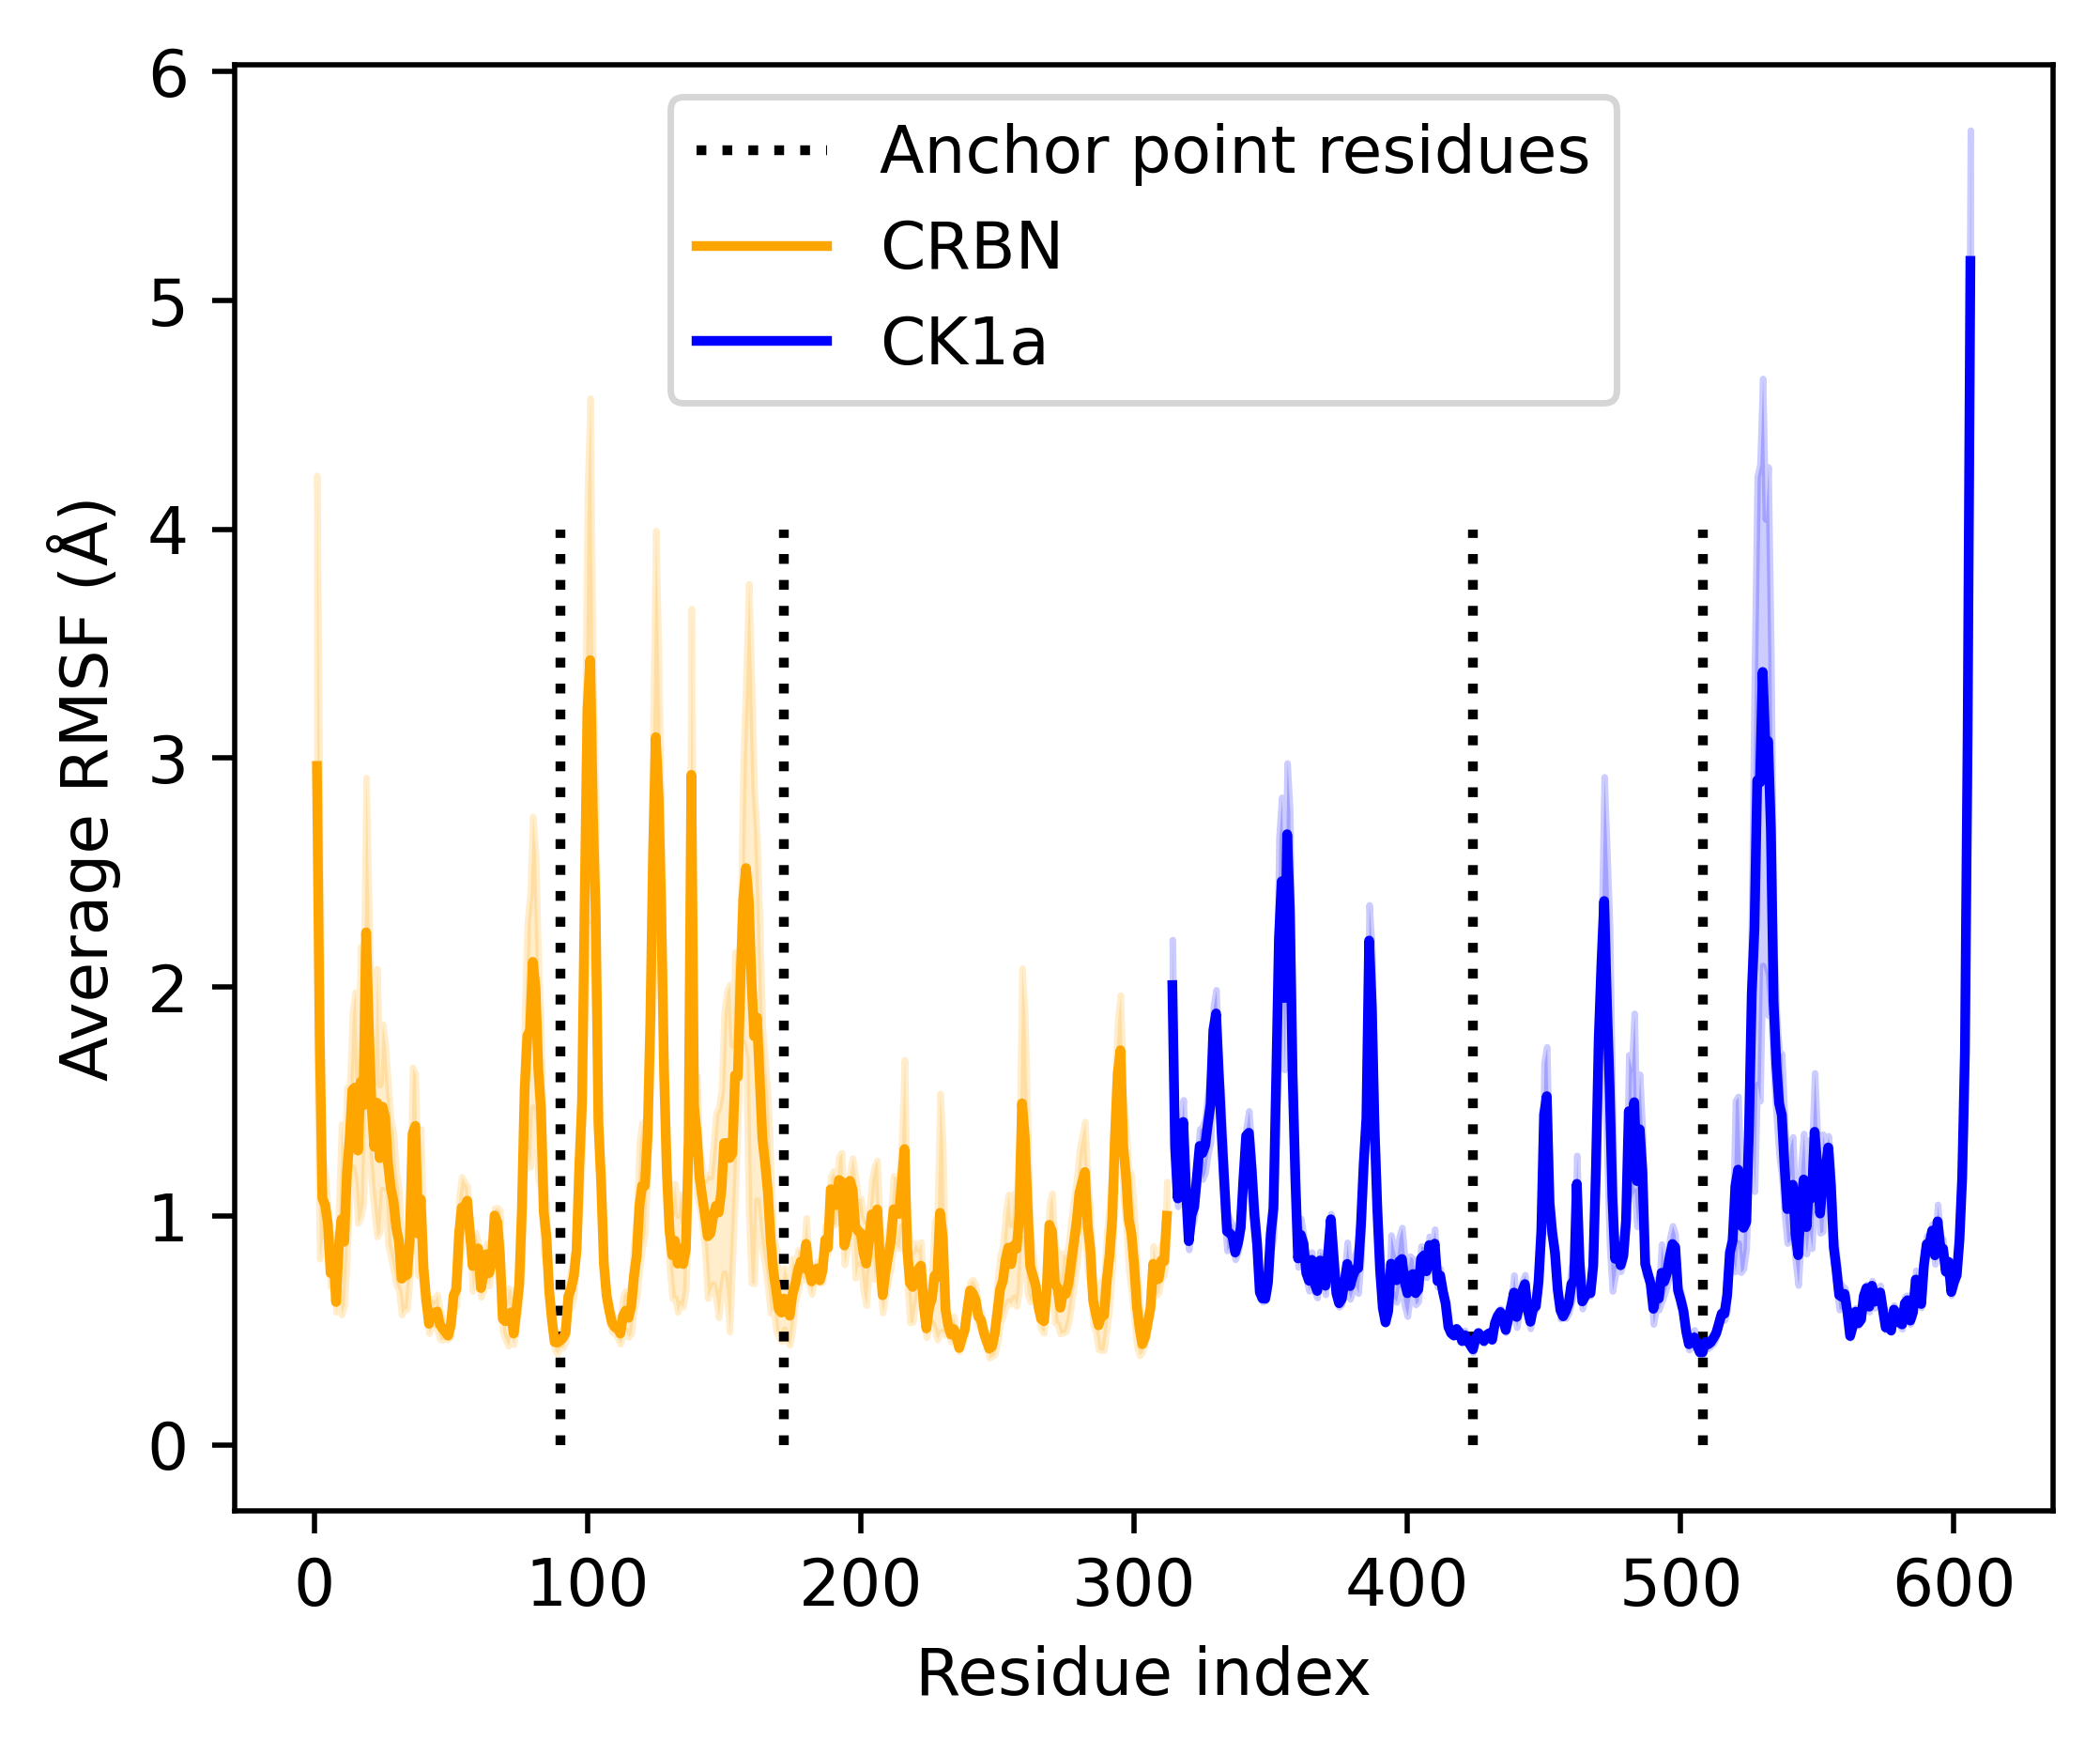

In [ ]:
# Boresch_residues = [13, 8, 142, 370, 332, 244]

runs = [1,2,3]

res_CRBN, av_RMSF_CRBN, std_RMSF_CRBN= obtain_av_RMSF(runs, species='CRBN')
res_CK1a, av_RMSF_CK1a, std_RMSF_CK1a= obtain_av_RMSF(runs, species='CK1a')

plt.figure(figsize=(5,4), dpi=500)
plt.vlines([90, 172,  424, 508], ymin=4*[0], ymax=4*[4], colors='k', linestyles='dotted', label='Anchor point residues')
plt.plot(res_CRBN, av_RMSF_CRBN, c='orange', label='CRBN')
plt.fill_between(res_CRBN, av_RMSF_CRBN-std_RMSF_CRBN, av_RMSF_CRBN+std_RMSF_CRBN, color='orange', alpha=0.2)
plt.plot(res_CK1a, av_RMSF_CK1a, c='blue', label='CK1a')
plt.fill_between(res_CK1a, av_RMSF_CK1a-std_RMSF_CK1a, av_RMSF_CK1a+std_RMSF_CK1a, color='blue', alpha=0.2)
plt.legend()
# plt.ylim(-0.1, 3.5)
plt.xlabel('Residue index')
plt.ylabel('Average RMSF (Å)')

In [16]:
"""Print Boresch DOFs"""

u = mda.Universe('structures/complex.prmtop', f'results/run1/traj.dcd')

save_idx = 50/100.2 * len(u.trajectory)
save_idx = int(np.round(save_idx, 6))

u.trajectory[save_idx]

rec_group =  [545, 562, 578, 1227, 1243, 3800, 3816, 3838, 3844, 3861, 3868, 3889, 3905, 4102, 4116, 4135, 4154, 4161, 4193, 4199, 4210, 4224, 4239, 4256, 4363, 4387, 4401, 4417, 4427, 4454, 4476, 4495, 4505, 4515, 4526, 4543, 4562, 4569, 4880, 9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9894, 9895, 9896, 9897, 9898, 9899, 9900, 9901, 9902, 9903, 9904]
lig_group =  [5078, 5100, 5121, 5358, 5377, 5387, 5406, 5420, 5439, 5453, 5467, 5474, 5489, 5504, 5520, 5941, 5958, 6028, 6045, 6064, 6292, 6309, 6321, 6340, 6359, 7215, 7222, 7241, 7248, 7272]

res_b = 90
res_c = 172 
res_B = 424 
res_C = 508 

idx_b = obtain_CA_idx(u, res_b)
idx_c = obtain_CA_idx(u, res_c)
idx_B = obtain_CA_idx(u, res_B)
idx_C = obtain_CA_idx(u, res_C)

pos_a = u.atoms[rec_group].center_of_mass()
pos_b = u.atoms[[idx_b]].center_of_mass()
pos_c = u.atoms[[idx_c]].center_of_mass()
pos_A = u.atoms[lig_group].center_of_mass()
pos_B = u.atoms[[idx_B]].center_of_mass()
pos_C = u.atoms[[idx_C]].center_of_mass()

print(f"ThetaA = {obtain_angle(pos_b, pos_a, pos_A)}")
print(f"ThetaB = {obtain_angle(pos_a, pos_A, pos_B)}")
print(f"PhiA = {obtain_dihedral(pos_c, pos_b, pos_a, pos_A)}")
print(f"PhiB = {obtain_dihedral(pos_b, pos_a, pos_A, pos_B)}")
print(f"PhiC = {obtain_dihedral(pos_a, pos_A, pos_B, pos_C)}\n")

print(f"Theta1 = {obtain_angle(pos_a, pos_b, pos_c)}")
print(f"Thetas = {obtain_angle(pos_A, pos_B, pos_C)}")

ThetaA = 2.453775900444169
ThetaB = 2.517762341731212
PhiA = 2.1335118554975967
PhiB = -2.2054696589928944
PhiC = 3.0357435385975733

Theta1 = 1.2320958934033213
Thetas = 2.1096722629955096


/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/topology/TOPParser.py:342: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using universe.guess_TopologyAttrs(to_guess=['elements']).
  warnings.warn(msg)
/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


## Saving the equilibrated structure

In [20]:
u = mda.Universe('structures/complex.prmtop', f'results/run1/traj.dcd')

save_idx = 50/100.2 * len(u.trajectory)
save_idx = int(np.round(save_idx, 6))

u.trajectory[save_idx]
u.atoms.write('equilibrated_structures/CRBN_len_CK1a_eq.pdb')

/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  warnings.warn("Found no information for attr: '{}'"
/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/home/btan/miniconda3/envs/openbiosim/lib/p

## Analysing interface residues

In [14]:
def getDistance(idx1, idx2, u):
    """
    Get the distance between two atoms in a universe.

    Parameters
    ----------
    idx1 : int
        Index of the first atom
    idx2 : int
        Index of the second atom
    u : MDAnalysis.Universe
        The MDA universe containing the atoms and
        trajectory.

    Returns
    -------
    distance : float
        The distance between the two atoms in Angstroms.
    """
    distance = dist(
        mda.AtomGroup([u.atoms[idx1]]),
        mda.AtomGroup([u.atoms[idx2]]),
        box=u.dimensions,
    )[2][0]
    return distance

def closest_residue_to_point(atoms, point):
    """Find the closest residue in a selection of atoms to a given point"""
    residues = atoms.residues
    distances = np.array([np.linalg.norm(res.atoms.center_of_mass() - point) for res in residues])

    # Find the index of the smallest distance
    closest_residue_index = np.argmin(distances)

    # Return the closest residue
    return residues[closest_residue_index], distances[closest_residue_index]

In [15]:
u = mda.Universe('structures/complex.prmtop', f'results/run1/traj.dcd')

save_idx = 50/100.2 * len(u.trajectory)
save_idx = int(np.round(save_idx, 6))

u.trajectory[save_idx]

receptor_selection_str="resid 1-312 and name CA" # CRBN
ligand_selection_str = "resid 314-606 and name CA" # CK1a

lenalidomide = u.select_atoms('resname LVY') 
ligand = u.select_atoms(ligand_selection_str)
receptor = u.select_atoms(receptor_selection_str)

# Find indices of lenalidomide heavy atoms
lenalidomide_indices = []
for atom in lenalidomide.atoms:
    if atom.name[0] != ('H'):
        lenalidomide_indices.append(atom.index)

ligand_interface = []
receptor_interface = []

# Save all ligand CA indices that are within 12 AA of a receptor CA
for lig_CA in ligand.atoms:
    
    for rec_CA in receptor.atoms:
        distance = getDistance(lig_CA.index, rec_CA.index, u)
        if distance <=12.000: 
            ligand_interface.append(int(lig_CA.index))
            receptor_interface.append(int(rec_CA.index))

# Returns interface residues
ligand_interface=set(ligand_interface)
receptor_interface=set(receptor_interface)   

receptor_interface_res = [
    int(u.select_atoms(f"index {index}").residues.resids[0]) for index in receptor_interface 
]

ligand_interface_res = [
    int(u.select_atoms(f"index {index}").residues.resids[0]) for index in ligand_interface 
]

# Add lenalidomide resid to the list of indices
receptor_interface_res.append(lenalidomide.resids[0])

print(f"\nReceptor interface residues = {sorted(receptor_interface_res)}")
print(f"Ligand interface residues = {sorted(ligand_interface_res)}\n")

rec_interface_selection = "index " + " ".join(map(str, list(receptor_interface)))
lig_interface_selection = "index " + " ".join(map(str, list(ligand_interface)))

# Calculate centers of mass
receptor_com = u.select_atoms(rec_interface_selection).center_of_mass()
ligand_com = u.select_atoms(lig_interface_selection).center_of_mass()

# Find the closest residues
closest_receptor_residue, dist_rec = closest_residue_to_point(u.select_atoms(rec_interface_selection), receptor_com)
closest_ligand_residue, dist_lig = closest_residue_to_point(u.select_atoms(lig_interface_selection), ligand_com)

print(f"CoM separation = {obtain_distance(receptor_com, ligand_com)}")

print(f"Closest residue to receptor COM: {closest_receptor_residue.resname} {closest_receptor_residue.resid}, distance is {dist_rec}")
print(f"Closest residue to ligand COM: {closest_ligand_residue.resname} {closest_ligand_residue.resid}, distance is {dist_lig}")

rec_group = sorted(list(receptor_interface)) + lenalidomide_indices 
print('\nrec_group = ', rec_group)

lig_group = sorted(list(ligand_interface)) 
print('lig_group = ', lig_group)

/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/topology/TOPParser.py:342: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using universe.guess_TopologyAttrs(to_guess=['elements']).
  warnings.warn(msg)
/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"



Receptor interface residues = [37, 38, 39, 79, 80, 237, 238, 239, 240, 241, 242, 243, 244, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 273, 274, 275, 276, 277, 279, 280, 281, 282, 283, 284, 285, 286, 287, 305, 607]
Ligand interface residues = [319, 320, 321, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 371, 372, 378, 379, 380, 393, 394, 395, 396, 397, 448, 449, 450, 451, 452]

CoM separation = 11.940132910603092
Closest residue to receptor COM: TRP 287, distance is 3.6339245862061453
Closest residue to ligand COM: VAL 346, distance is 2.922062427622232

rec_group =  [545, 562, 578, 1227, 1243, 3800, 3816, 3838, 3844, 3861, 3868, 3889, 3905, 4102, 4116, 4135, 4154, 4161, 4193, 4199, 4210, 4224, 4239, 4256, 4363, 4387, 4401, 4417, 4427, 4454, 4476, 4495, 4505, 4515, 4526, 4543, 4562, 4569, 4880, 9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9894, 9895, 9896, 9897, 9898, 9899, 9900, 9901, 9902, 9903, 9904]
lig_group =  [5078, 5100, 5121, 5358, 5377, 5387, 5406

### Boresch dof

In [16]:
def obtain_Boresch_dof(run_number, dof):

    boreschfile = f'results/run{run_number}/{dof}.pkl'

    with open(boreschfile, 'rb') as f:
        loaded_data = pickle.load(f)

    frames = loaded_data['Frames']
    time = loaded_data['Time (ns)']
    vals = loaded_data['DOF values']

    return time, vals

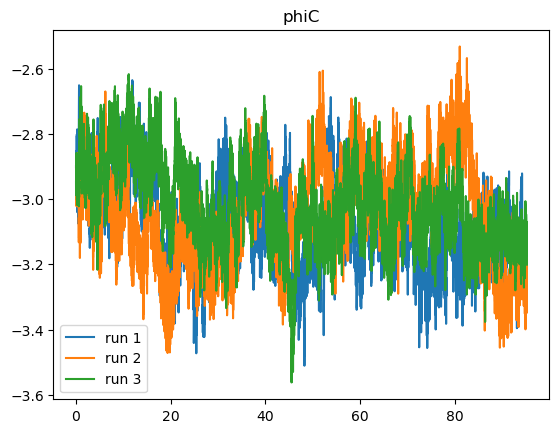

In [23]:
"""Plotting the time evolution of the DOF"""

dof = 'phiC'
positive = False

plt.title(dof)
for run_number in [1,2,3]:
    time, vals = obtain_Boresch_dof(run_number, dof)

    for n in range(len(vals)):
        if positive == True:
            if vals[n] < 0:
                vals[n] = vals[n] + 2*np.pi
        else:
            if vals[n] > 0:
                vals[n] = vals[n] - 2*np.pi

    plt.plot(time, vals, label=f"run {run_number}")

plt.legend()


In [ ]:
"""Plotting the histogram"""

dof = 'phiC'
equil_time = 40.0  # ns
cutoff_time = 90.0  # ns

positive = False

titles = {'thetaA':'$\Theta _A$', 'thetaB':'$\Theta _B$', 'phiA':'$\phi _A$', 'phiB':'$\phi _B$', 'phiC':'$\phi _C$'}

vals_all = []
plt.figure(figsize=(4,3), dpi=500)
plt.title(titles[dof])

for run_number in [1,2,3]:
    time, vals = obtain_Boresch_dof(run_number, dof)

    for n in range(len(vals)):
        if positive == True:
            if vals[n] < 0:
                vals[n] = vals[n] + 2*np.pi
        else:
            if vals[n] > 0:
                vals[n] = vals[n] - 2*np.pi

    # get indices robustly from the actual time array
    start_idx = np.searchsorted(time, equil_time, side='left')
    end_idx = np.searchsorted(time, cutoff_time, side='right')  # exclusive end

    # slice
    time_slice = time[start_idx:end_idx]
    vals_slice = vals[start_idx:end_idx]

    # collect values across runs
    vals_all.append(vals_slice)

# combine all runs
if len(vals_all) == 0:
    raise RuntimeError("No data in the requested time window.")
vals_all = np.concatenate(vals_all)

# histogram
counts, bins = np.histogram(vals_all, bins=50)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
peak_center = bin_centers[counts.argmax()]
print(peak_center)

plt.hist(vals_all, bins=50)
plt.vlines(peak_center, ymin=0, ymax=counts.max() * 1.1, colors='k', linestyles='dotted', label='Equilibrium value')
plt.yticks([])
plt.xlabel('radians')
plt.show()

### Saving equilibrated structure

In [ ]:
u = mda.Universe('structures/complex.prmtop', f'results/run0/traj.dcd')

total_time_ns=100.2
total_frames = 10020
frames_per_ns = total_frames / total_time_ns
frame_15ns = int(frames_per_ns * 15)

# Load the trajectory
u = mda.Universe('structures/complex.prmtop', f'results/run{run_number}/traj.dcd')

u.trajectory[frame_15ns]

u.atoms.write(f'results/structures/15_ns.pdb')

In [221]:
from pymol import cmd

cmd.reinitialize()

cmd.load(f"results/structures/15_ns.pdb", "complex")

cmd.remove("resn HOH")
cmd.remove("resn WAT")
cmd.remove("hydro")
cmd.remove("resn CL")

cmd.save(f"results/structures/complex_eq_noH.pdb")


## Analysis of interface CoM

In [2]:
def obtain_CA_idx(u, res_idx):
    """Function to obtain the index of the alpha carbon for a given residue index"""
    
    selection_str = f"protein and resid {res_idx} and name CA"
    
    selected_CA = u.select_atoms(selection_str)

    if len(selected_CA.indices) == 0:
        print('CA not found for the specified residue...')
    
    elif len(selected_CA.indices) > 1:
        print('Multiple CAs found, uh oh...')

    else:  
        return selected_CA.indices[0]

def obtain_distance(pos1, pos2):
    """Obtain the distance between two coordinates"""
    return np.linalg.norm(pos1 - pos2)

In [19]:
u = mda.Universe('structures/complex.prmtop', f'structures/complex.inpcrd')

rec_group =  [545, 562, 578, 1227, 1243, 3800, 3816, 3838, 3844, 3861, 3868, 3889, 3905, 4102, 4116, 4135, 4154, 4161, 4193, 4199, 4210, 4224, 4239, 4256, 4363, 4387, 4401, 4417, 4427, 4454, 4476, 4495, 4505, 4515, 4526, 4543, 4562, 4569, 4880, 9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9894, 9895, 9896, 9897, 9898, 9899, 9900, 9901, 9902, 9903, 9904]
lig_group =  [5078, 5100, 5121, 5358, 5377, 5387, 5406, 5420, 5439, 5453, 5467, 5474, 5489, 5504, 5520, 5941, 5958, 6028, 6045, 6064, 6292, 6309, 6321, 6340, 6359, 7215, 7222, 7241, 7248, 7272]

rec_atoms = u.atoms[rec_group]
lig_atoms = u.atoms[lig_group]

In [20]:
CoM_sep_data = {}

for n_run in [1,2,3]:
    sep = []
    u = mda.Universe('structures/complex.prmtop', f'results/run{n_run}/traj.dcd')
    
    for ts in tqdm(u.trajectory, total=len(u.trajectory), desc='Frames analysed'):
    
        rec_atoms = u.atoms[rec_group]
        lig_atoms = u.atoms[lig_group] 

        rec_COM = rec_atoms.center_of_mass()
        lig_COM = lig_atoms.center_of_mass()

        sep.append(obtain_distance(rec_COM, lig_COM))

    CoM_sep_data[n_run] = sep

/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
Frames analysed: 100%|██████████| 10020/10020 [00:09<00:00, 1083.51it/s]


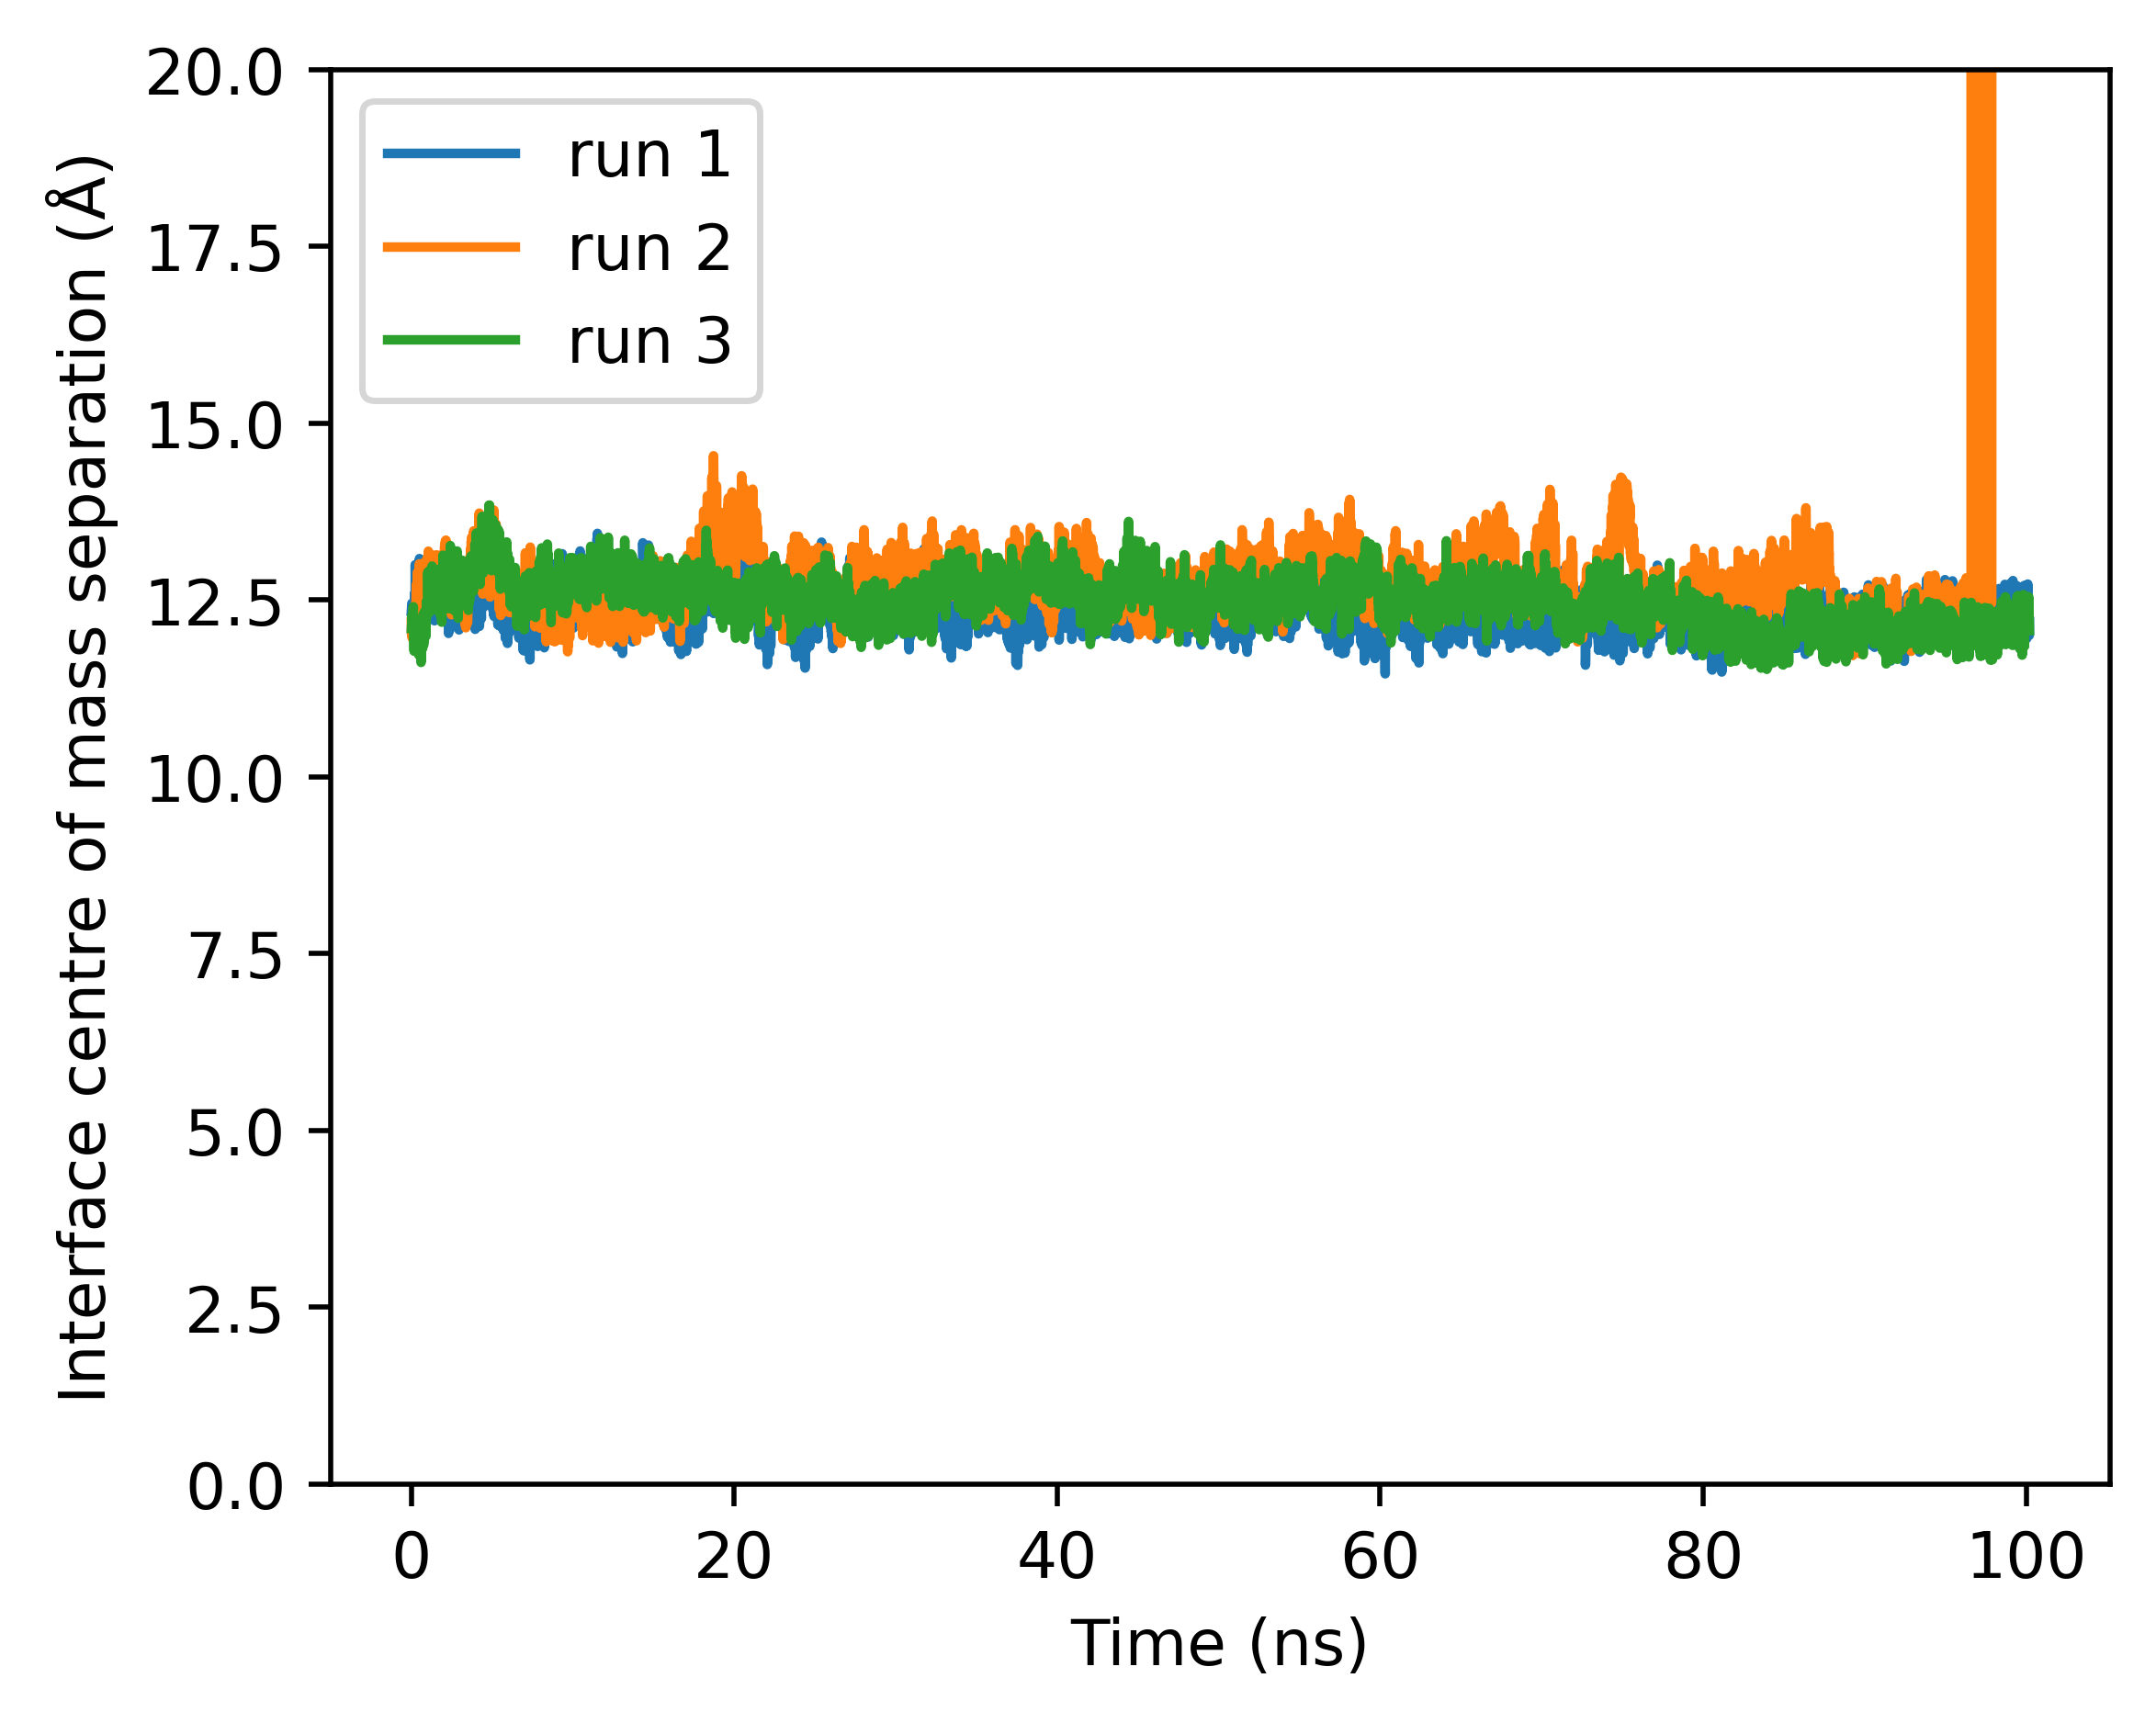

In [21]:
plt.figure(figsize=(5,4), dpi=500)

labels = {0:1, 2:2, 4:3}

for n_run in [1,2,3]:
    x = np.linspace(0,100.204,len(CoM_sep_data[n_run]))
    plt.plot(x, CoM_sep_data[n_run], label=f"run {n_run}")

plt.ylim(0,20)
plt.ylabel('Interface centre of mass separation (Å)')
plt.xlabel('Time (ns)')
plt.legend()
plt.show()